In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from pathlib import Path

In [2]:
df = pd.read_csv("data/flickr_data_cleaned.csv", parse_dates=["date_taken", "date_upload"])
df.head(5)

,id,user,lat,long,tags,title,date_upload,date_taken
0,4395181099,30624617@N03,45.754858,4.821710,"chair,lyon,rhône,chaise,rhônealpes",Chaises avec vue,2010-02-28 20:23:00,2010-02-28 15:11:00
1,4394748717,35853470@N00,45.753270,4.862953,NaN,NaN,2010-02-28 17:52:00,2010-02-28 17:51:00
2,4394694699,11817998@N05,45.760655,4.846564,"365,iphone",59/365 - R46 V103 B163,2010-02-28 17:33:00,2010-02-28 17:29:00
3,4394803790,11545749@N06,45.784000,4.874072,"nin,nineinchnails,gift,screening,toiou,avott",2010-01-29 Toiou Avott Lyon,2010-02-28 12:38:00,2010-01-28 20:15:00
4,4394803554,11545749@N06,45.784000,4.874072,"lyon,nin,nineinchnails,gift,screening,toiou,avott",2010-01-28 Toiou Avott Lyon,2010-02-28 12:38:00,2010-01-28 20:10:00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185209 entries, 0 to 185208
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           185209 non-null  int64         
 1   user         185209 non-null  object        
 2   lat          185209 non-null  float64       
 3   long         185209 non-null  float64       
 4   tags         138805 non-null  object        
 5   title        168309 non-null  object        
 6   date_upload  185209 non-null  datetime64[ns]
 7   date_taken   185209 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 11.3+ MB


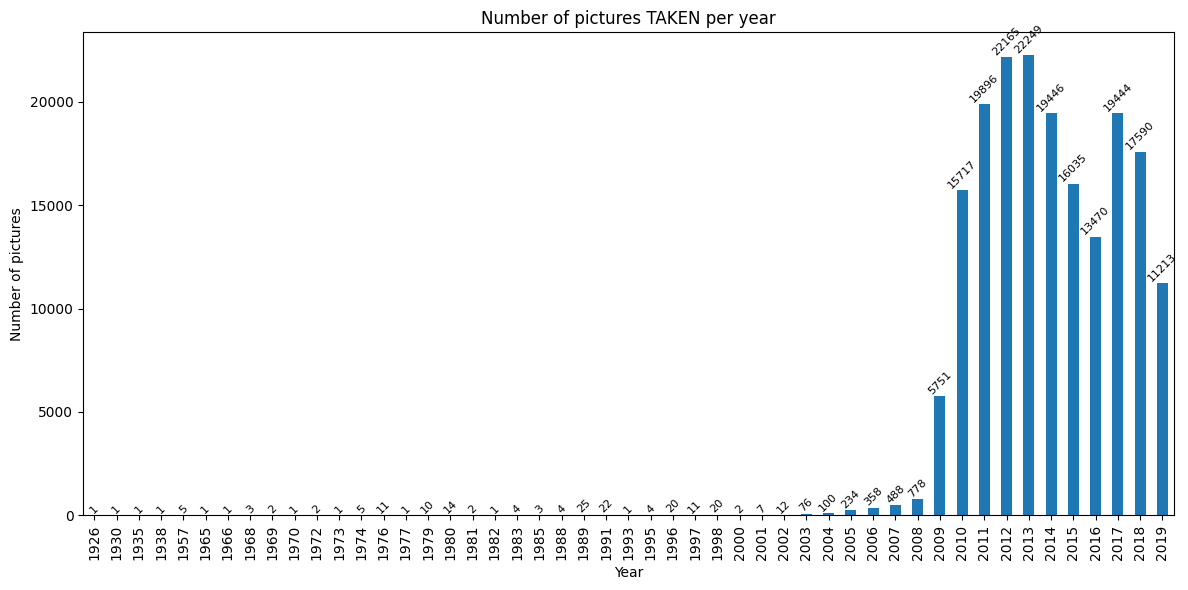

In [4]:
ax = df["date_taken"].dt.year.value_counts().sort_index().plot(kind="bar", figsize=(12, 6))
plt.title("Number of pictures TAKEN per year")
plt.xlabel("Year")
plt.ylabel("Number of pictures")

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

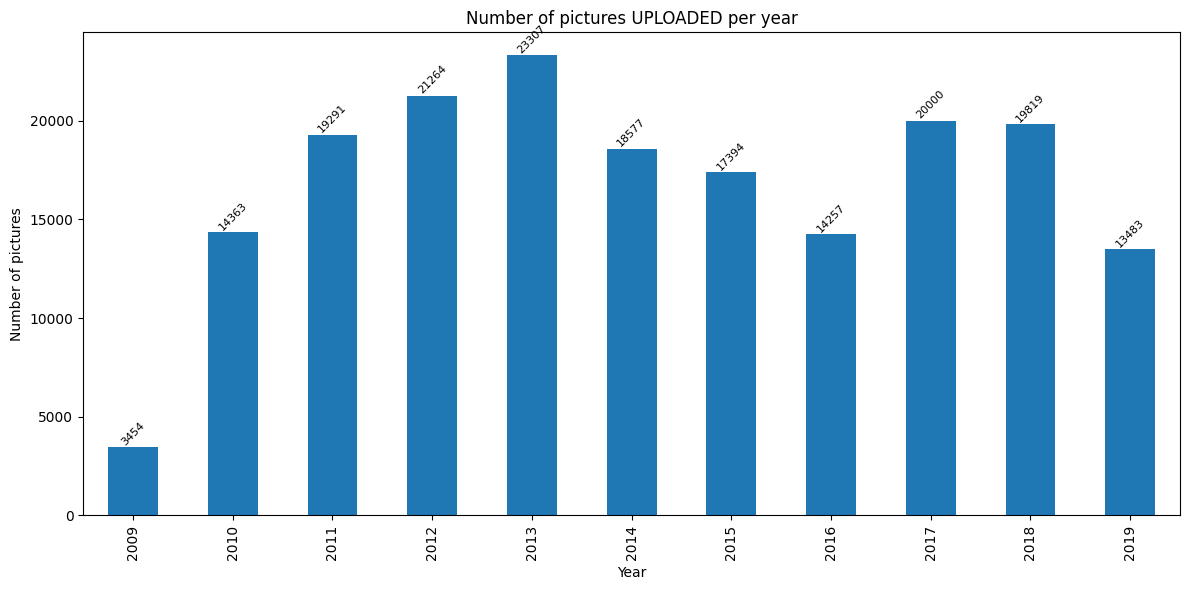

In [5]:
ax = df["date_upload"].dt.year.value_counts().sort_index().plot(kind="bar", figsize=(12, 6))
plt.title("Number of pictures UPLOADED per year")
plt.xlabel("Year")
plt.ylabel("Number of pictures")

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

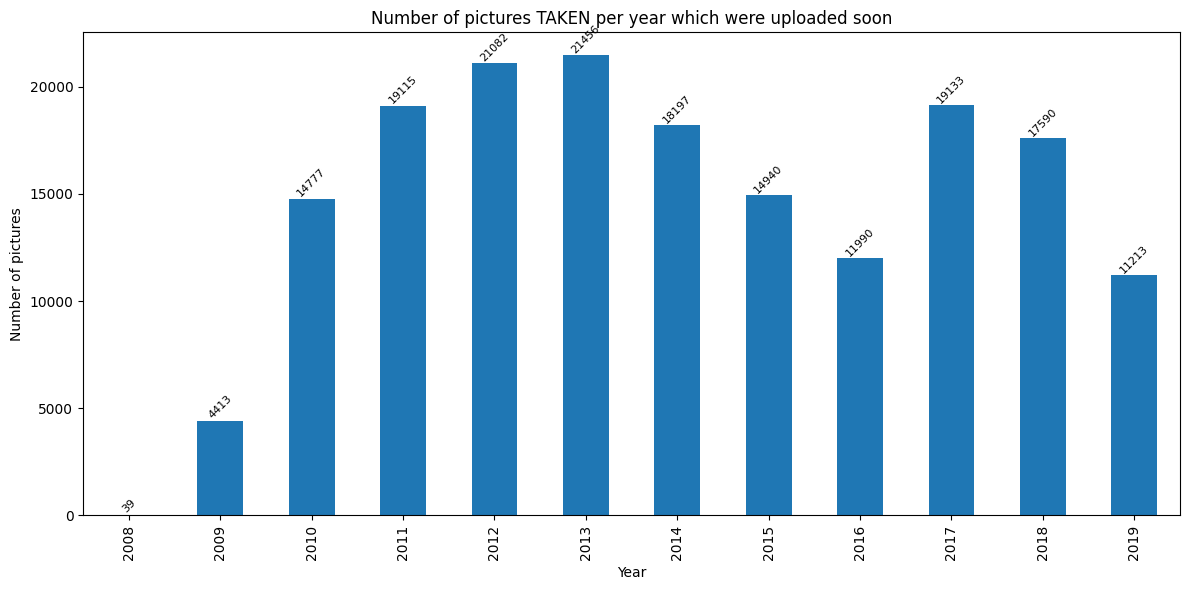

In [6]:
# distribution of pictures with the small difference between date_taken and date_upload
similar_mask = df["date_upload"].dt.year - df["date_taken"].dt.year <= 1
similar_year = df[similar_mask]
ax = similar_year["date_taken"].dt.year.value_counts().sort_index().plot(kind="bar", figsize=(12, 6))
plt.title("Number of pictures TAKEN per year which were uploaded soon")
plt.xlabel("Year")
plt.ylabel("Number of pictures")

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

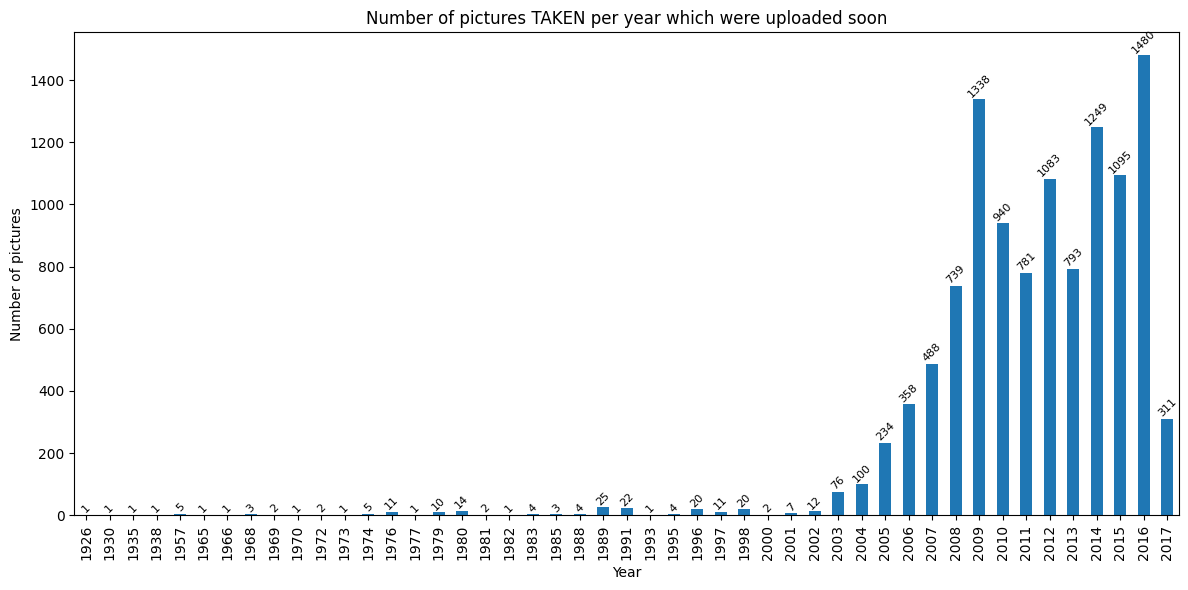

In [7]:
diff_year = df[~similar_mask]
ax = diff_year["date_taken"].dt.year.value_counts().sort_index().plot(kind="bar", figsize=(12, 6))
plt.title("Number of pictures TAKEN per year which were uploaded soon")
plt.xlabel("Year")
plt.ylabel("Number of pictures")

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

In [8]:
df['similar_year'] = similar_mask

In [9]:
save_dir = Path("./data/explore/")
save_dir.mkdir(parents=True, exist_ok=True)

m = folium.Map(location=[45.75, 4.85], zoom_start=12)  # Centered on Lyon, France
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["long"]],
        radius=2,
        color="blue" if row["similar_year"] else "red",
        fill=True,
        fill_color="blue",
        fill_opacity=0.6,
    ).add_to(m)

m.save(str(save_dir / "all_points_map.html"))